**Import Packages**

In [2]:
import pycaret
import pandas as pd
import numpy as np
import sqlalchemy
import mysql.connector

from pycaret import classification
from pycaret.classification import plot_model
from datetime import datetime
import importlib
import model.common

In [3]:
from static_data.load_static_data import *

In [4]:
df_player_team_positions

,Unnamed: 0,player_id,player_name,player_team_id,player_team_name,player_position
0,0,456167,A.J. Griffin,133,Oakland Athletics,Pitcher
1,0,134460,A.J. Hinch,133,Oakland Athletics,Catcher
2,0,640462,A.J. Puk,133,Oakland Athletics,Pitcher
3,0,605156,Aaron Brooks,133,Oakland Athletics,Pitcher
4,0,488811,Aaron Cunningham,133,Oakland Athletics,Outfielder
...,...,...,...,...,...,...
44728,0,451596,Yovani Gallardo,113,Cincinnati Reds,Pitcher
44729,0,435043,Zach Duke,113,Cincinnati Reds,Pitcher
44730,0,572227,Zach Vincej,113,Cincinnati Reds,Infielder
44731,0,446359,Zack Cozart,113,Cincinnati Reds,Infielder


**Load Data**

In [5]:
collect_data_Base_dir = 'collect_data'

In [6]:
df_game_matchup_total = pd.read_pickle(f'{collect_data_Base_dir}/df_game_matchup_total.pkl')
print(len(df_game_matchup_total))

322963


**Clean Data**

In [117]:
importlib.reload(model.common)

<module 'model.common' from '/home/junlim/projects/mlb-props/model/common.py'>

In [8]:
model.common.categorical_features

['game_venue', 'batting_name', 'pitching_name']

In [9]:
train_data = df_game_matchup_total[(df_game_matchup_total.game_date > "2012-04-01") & (df_game_matchup_total.game_date < "2022-12-01")][model.common.features]
test_data = df_game_matchup_total[(df_game_matchup_total.game_date > "2022-12-01")][model.common.features]

In [10]:
train_data.columns

Index(['pitching_gamesPlayed', 'pitching_runs_per_game',
       'pitching_strikeOuts_per_game', 'pitching_hits_per_game', 'pitching_id',
       'batting_name', 'batting_gamesPlayed', 'batting_runs_per_game',
       'batting_strikeOuts_per_game', 'batting_hits_per_game', 'batting_rbi',
       'batting_id', 'pitching_name', 'batting_hit_recorded',
       'pitching_cur_season_runs_per_game',
       'pitching_cur_season_strikeOuts_per_game',
       'pitching_cur_season_hits_per_game', 'batting_cur_season_runs_per_game',
       'batting_cur_season_strikeOuts_per_game',
       'batting_cur_season_hits_per_game', 'temp', 'game_venue', 'game_date',
       'game_year'],
      dtype='object')

In [11]:
test_data.columns

Index(['pitching_gamesPlayed', 'pitching_runs_per_game',
       'pitching_strikeOuts_per_game', 'pitching_hits_per_game', 'pitching_id',
       'batting_name', 'batting_gamesPlayed', 'batting_runs_per_game',
       'batting_strikeOuts_per_game', 'batting_hits_per_game', 'batting_rbi',
       'batting_id', 'pitching_name', 'batting_hit_recorded',
       'pitching_cur_season_runs_per_game',
       'pitching_cur_season_strikeOuts_per_game',
       'pitching_cur_season_hits_per_game', 'batting_cur_season_runs_per_game',
       'batting_cur_season_strikeOuts_per_game',
       'batting_cur_season_hits_per_game', 'temp', 'game_venue', 'game_date',
       'game_year'],
      dtype='object')

In [12]:
model.common.categorical_features

['game_venue', 'batting_name', 'pitching_name']

In [13]:
model.common.ignore_features

['pitching_id', 'batting_id', 'game_date', 'game_year']

**Model Setup**

In [14]:
classification_setup = pycaret.classification.setup(
    data = train_data, target = "batting_hit_recorded", train_size = .70, use_gpu = False, 
    categorical_features = ['game_venue'], ignore_features = model.common.ignore_features + ['batting_name', 'pitching_name'])

,Description,Value
0,Session id,1065
1,Target,batting_hit_recorded
2,Target type,Binary
3,Original data shape,"(285515, 24)"
4,Transformed data shape,"(285515, 18)"
5,Transformed train set shape,"(199860, 18)"
6,Transformed test set shape,"(85655, 18)"
7,Ignore features,6
8,Numeric features,16
9,Categorical features,1


**Build/Train Model**

In [15]:
classification_setup.create_model?

Signature:
classification_setup.create_model(
    estimator: Union[str, Any],
    fold: Union[int, Any, NoneType] = None,
    round: int = 4,
    cross_validation: bool = True,
    fit_kwargs: Optional[dict] = None,
    groups: Union[str, Any, NoneType] = None,
    experiment_custom_tags: Optional[Dict[str, Any]] = None,
    probability_threshold: Optional[float] = None,
    engine: Optional[str] = None,
    verbose: bool = True,
    return_train_score: bool = False,
    **kwargs,
) -> Any
Docstring:
This function trains and evaluates the performance of a given estimator
using cross validation. The output of this function is a score grid with
CV scores by fold. Metrics evaluated during CV can be accessed using the
``get_metrics`` function. Custom metrics can be added or removed using
``add_metric`` and ``remove_metric`` function. All the available models
can be accessed using the ``models`` function.

Example
-------
>>> from pycaret.datasets import get_data
>>> juice = get_data('juice

In [16]:
regression_model_lr = classification_setup.create_model("lr", probability_threshold = 0.50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6286,0.6530,0.8097,0.6334,0.7108,0.2131,0.2260
1,0.6202,0.6456,0.8029,0.6274,0.7044,0.1950,0.2069
2,0.6278,0.6540,0.8091,0.6328,0.7102,0.2113,0.2240
3,0.6293,0.6510,0.8130,0.6334,0.7120,0.2139,0.2274
4,0.6303,0.6570,0.8124,0.6343,0.7124,0.2163,0.2296
5,0.6367,0.6644,0.8026,0.6422,0.7135,0.2335,0.2445
6,0.6275,0.6539,0.8123,0.6319,0.7108,0.2098,0.2232
7,0.6323,0.6591,0.8069,0.6372,0.7121,0.2223,0.2344
8,0.6332,0.6613,0.8052,0.6384,0.7122,0.2248,0.2366


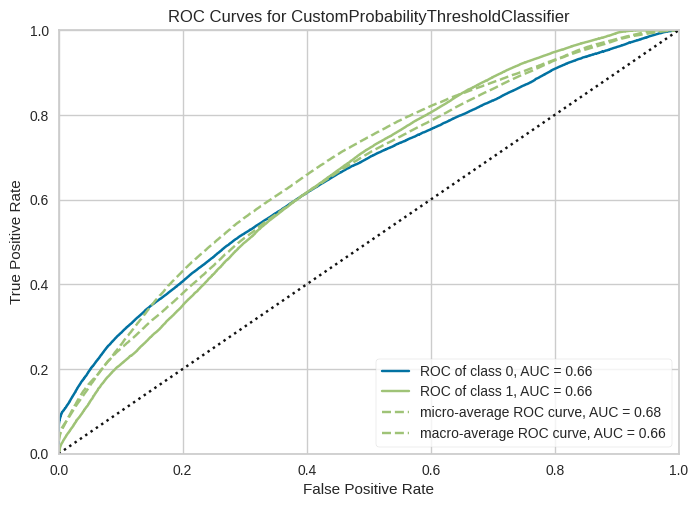

In [22]:
plot_model(regression_model_lr, plot = 'auc')

In [106]:
regression_model_rf = classification_setup.create_model("rf", probability_threshold = 0.50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9989,1.0000,0.9982,0.9999,0.9991,0.9979,0.9979
1,0.9995,1.0000,0.9991,1.0000,0.9996,0.9990,0.9990
2,0.9994,1.0000,0.9990,1.0000,0.9995,0.9989,0.9989
3,0.9991,1.0000,0.9986,0.9998,0.9992,0.9982,0.9982
4,0.9991,1.0000,0.9987,0.9997,0.9992,0.9982,0.9982
5,0.9991,1.0000,0.9986,0.9998,0.9992,0.9982,0.9982
6,0.9991,1.0000,0.9988,0.9997,0.9992,0.9983,0.9983
7,0.9993,1.0000,0.9988,1.0000,0.9994,0.9986,0.9986
8,0.9991,1.0000,0.9986,0.9999,0.9992,0.9983,0.9983


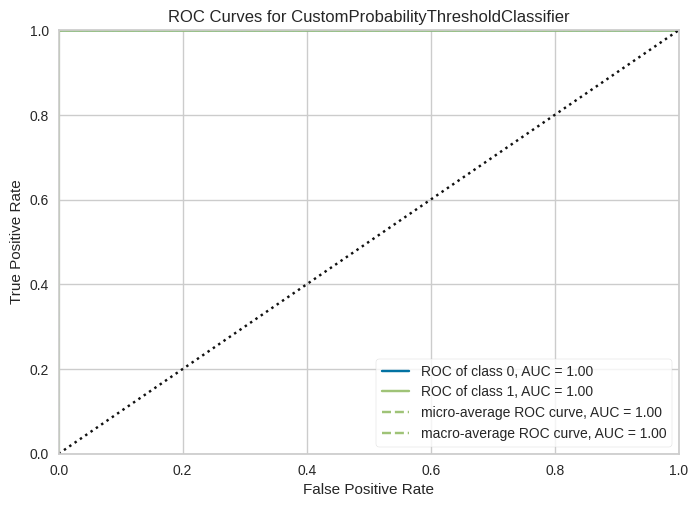

In [107]:
plot_model(regression_model_rf, plot = 'auc')

In [17]:
regression_model_gbc = classification_setup.create_model("gbc", probability_threshold = 0.50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6893,0.7807,0.8771,0.6719,0.7609,0.3390,0.3643
1,0.6733,0.7628,0.8650,0.6605,0.7490,0.3045,0.3279
2,0.6845,0.7805,0.8652,0.6706,0.7556,0.3302,0.3521
3,0.6898,0.7784,0.8751,0.6729,0.7608,0.3404,0.3649
4,0.6820,0.7756,0.8675,0.6677,0.7546,0.3240,0.3470
5,0.6933,0.7800,0.8690,0.6778,0.7616,0.3497,0.3715
6,0.6860,0.7735,0.8756,0.6693,0.7587,0.3317,0.3570
7,0.6917,0.7781,0.8743,0.6748,0.7617,0.3450,0.3689
8,0.6892,0.7841,0.8708,0.6734,0.7595,0.3399,0.3630


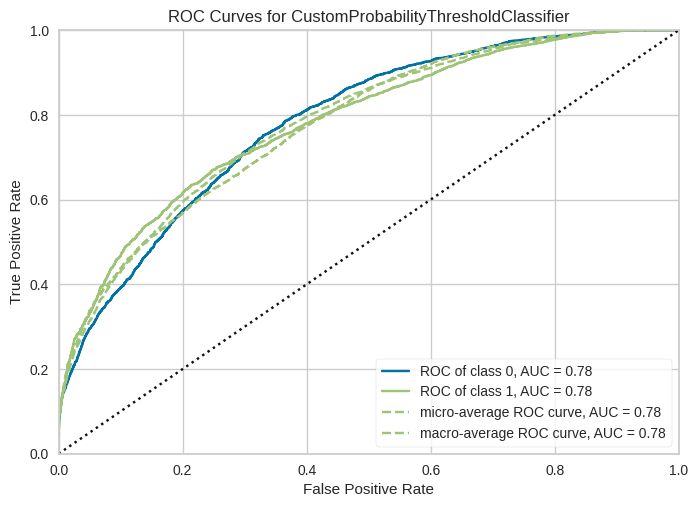

In [20]:
plot_model(regression_model_gbc, plot = 'auc')

In [19]:
regression_model_lightgbm = classification_setup.create_model("lightgbm", probability_threshold = 0.50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8816,0.9617,0.9452,0.8589,0.9000,0.7558,0.7610
1,0.8706,0.9590,0.9421,0.8459,0.8914,0.7325,0.7390
2,0.8862,0.9633,0.9405,0.8684,0.9030,0.7658,0.7693
3,0.8840,0.9653,0.9502,0.8589,0.9023,0.7604,0.7663
4,0.8833,0.9643,0.9446,0.8616,0.9012,0.7593,0.7641
5,0.8913,0.9658,0.9443,0.8731,0.9073,0.7763,0.7798
6,0.8987,0.9686,0.9561,0.8757,0.9141,0.7913,0.7959
7,0.8922,0.9649,0.9490,0.8712,0.9085,0.7780,0.7822
8,0.8921,0.9661,0.9466,0.8727,0.9081,0.7779,0.7816


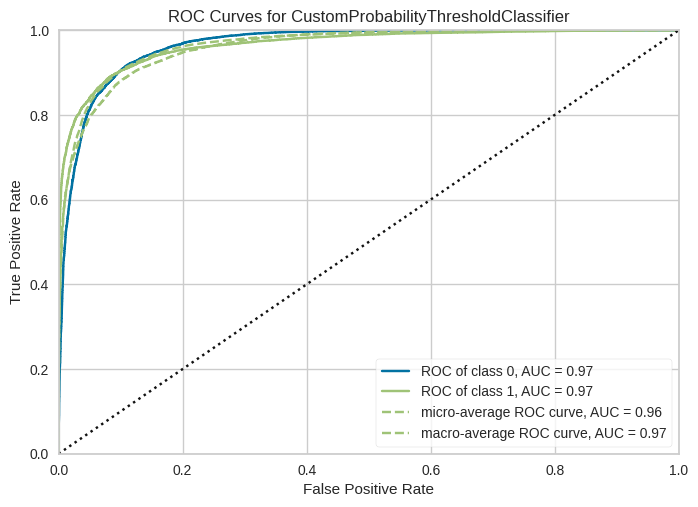

In [21]:
plot_model(regression_model_lightgbm, plot = 'auc')

In [81]:
regression_model_ada = classification_setup.create_model("ada", probability_threshold = 0.50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6480,0.6920,0.8636,0.6389,0.7345,0.2457,0.2714
1,0.6389,0.6830,0.8381,0.6365,0.7235,0.2305,0.2492
2,0.6467,0.6922,0.8700,0.6365,0.7352,0.2412,0.2692
3,0.6482,0.6945,0.8440,0.6432,0.7301,0.2507,0.2704
4,0.6448,0.6934,0.8577,0.6374,0.7313,0.2395,0.2635
5,0.6493,0.6983,0.8638,0.6399,0.7352,0.2487,0.2744
6,0.6435,0.6884,0.8594,0.6359,0.7310,0.2360,0.2606
7,0.6482,0.6970,0.8659,0.6385,0.7350,0.2456,0.2721
8,0.6529,0.7048,0.8683,0.6420,0.7382,0.2561,0.2830


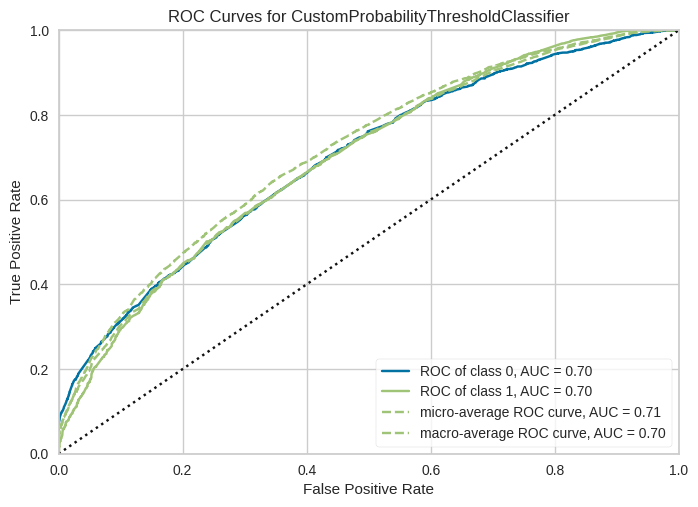

In [82]:
plot_model(regression_model_ada, plot = 'auc')

**evaluate model**

`lightgbm` shows very good AUC of `0.97`, `rf` as well with `1.0` train AUC.

`rf` seemed like too overfit with 1.0 train AUC but its test precision as well is the best among others.

`ada` shows very low recall thus inpractical.


In [142]:
def predict_and_odds(df_data, regression_model):
    df_prediction = pycaret.classification.predict_model(data = df_data, estimator = regression_model)
    df_prediction = pd.merge(df_prediction, df_player_team_positions[['player_id','player_team_name']], left_on='batting_id', right_on='player_id', how='left')
    df_prediction["theo_odds"] = df_prediction["prediction_score"].apply(model.common.odds_calculator)
    return df_prediction

In [143]:
def get_eval_profile(df_prediction, score_threshold):
    confident_prediction = df_prediction[(df_prediction["prediction_score"] >= score_threshold) & (df_prediction["prediction_label"] == 1)].sort_values(by = "prediction_score", ascending = False).drop_duplicates("batting_name")
    confident_prediction[['game_date', "batting_name", "batting_hit_recorded",	"prediction_score", "player_team_name", "theo_odds"]]
    l =len(confident_prediction)
    return l, confident_prediction.batting_hit_recorded.sum() / l

In [165]:
regression_model = regression_model_rf

In [175]:
train_prediction_lr = predict_and_odds(train_data, regression_model_lr)
train_prediction_gbc = predict_and_odds(train_data, regression_model_gbc)
train_prediction_lightgbm = predict_and_odds(train_data, regression_model_lightgbm)
train_prediction_rf = predict_and_odds(train_data, regression_model_rf)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.6290,0.6553,0.8061,0.6345,0.7101,0.2148,0.2270


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.6875,0.7838,0.8665,0.6731,0.7576,0.3370,0.3589


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8933,0.9673,0.9521,0.8706,0.9095,0.7800,0.7846


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9998,1.0000,0.9997,1.0000,0.9999,0.9997,0.9997


In [176]:
print(get_eval_profile(train_prediction_lr, 0.6))
print(get_eval_profile(train_prediction_lr, 0.7))
print(get_eval_profile(train_prediction_lr, 0.75))
print(get_eval_profile(train_prediction_lr, 0.80))

(629, 0.7090620031796503)
(331, 0.7250755287009063)
(181, 0.7845303867403315)
(53, 0.7924528301886793)


In [177]:
print(get_eval_profile(train_prediction_gbc, 0.6))
print(get_eval_profile(train_prediction_gbc, 0.7))
print(get_eval_profile(train_prediction_gbc, 0.75))
print(get_eval_profile(train_prediction_gbc, 0.80))

(630, 0.8412698412698413)
(336, 0.9136904761904762)
(193, 0.9533678756476683)
(104, 0.9903846153846154)


In [178]:
print(get_eval_profile(train_prediction_lightgbm, 0.6))
print(get_eval_profile(train_prediction_lightgbm, 0.7))
print(get_eval_profile(train_prediction_lightgbm, 0.75))
print(get_eval_profile(train_prediction_lightgbm, 0.80))

(792, 0.9507575757575758)
(576, 0.9861111111111112)
(472, 0.9978813559322034)
(340, 0.9970588235294118)


In [179]:
print(get_eval_profile(train_prediction_rf, 0.6))
print(get_eval_profile(train_prediction_rf, 0.7))
print(get_eval_profile(train_prediction_rf, 0.75))
print(get_eval_profile(train_prediction_rf, 0.80))

(1091, 1.0)
(1075, 1.0)
(1058, 1.0)
(1042, 1.0)


**test prediction**

In [180]:
test_prediction_lr = predict_and_odds(test_data, regression_model_lr)
test_prediction_gbc = predict_and_odds(test_data, regression_model_gbc)
test_prediction_lightgbm = predict_and_odds(test_data, regression_model_lightgbm)
test_prediction_rf = predict_and_odds(test_data, regression_model_rf)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5923,0.6167,0.7517,0.6261,0.6831,0.1248,0.1290


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.6157,0.6297,0.8078,0.6346,0.7108,0.1621,0.1729


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.5852,0.6167,0.7283,0.6246,0.6725,0.1160,0.1186


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.6156,0.6275,0.7735,0.6422,0.7018,0.1741,0.1801


In [181]:
print(get_eval_profile(test_prediction_lr, 0.6))
print(get_eval_profile(test_prediction_lr, 0.7))
print(get_eval_profile(test_prediction_lr, 0.75))
print(get_eval_profile(test_prediction_lr, 0.80))
print(get_eval_profile(test_prediction_lr, 0.85))

(183, 0.6721311475409836)
(75, 0.7466666666666667)
(31, 0.7741935483870968)
(10, 1.0)
(2, 1.0)


In [182]:
print(get_eval_profile(test_prediction_gbc, 0.6))
print(get_eval_profile(test_prediction_gbc, 0.7))
print(get_eval_profile(test_prediction_gbc, 0.75))
print(get_eval_profile(test_prediction_gbc, 0.80))
print(get_eval_profile(test_prediction_gbc, 0.85))

(174, 0.6839080459770115)
(61, 0.7540983606557377)
(20, 1.0)
(13, 1.0)
(4, 1.0)


In [183]:
print(get_eval_profile(test_prediction_lightgbm, 0.6))
print(get_eval_profile(test_prediction_lightgbm, 0.7))
print(get_eval_profile(test_prediction_lightgbm, 0.75))
print(get_eval_profile(test_prediction_lightgbm, 0.80))
print(get_eval_profile(test_prediction_lightgbm, 0.85))

(185, 0.6648648648648648)
(87, 0.735632183908046)
(61, 0.7868852459016393)
(27, 0.7777777777777778)
(9, 0.8888888888888888)


In [184]:
print(get_eval_profile(test_prediction_rf, 0.6))
print(get_eval_profile(test_prediction_rf, 0.7))
print(get_eval_profile(test_prediction_rf, 0.75))
print(get_eval_profile(test_prediction_rf, 0.80))
print(get_eval_profile(test_prediction_rf, 0.85))

(215, 0.6558139534883721)
(114, 0.6666666666666666)
(61, 0.7377049180327869)
(25, 0.88)
(8, 1.0)


**Finalize Model**

In [185]:
# train over the whole dataset without validation split
regression_model_finalized_lr = pycaret.classification.finalize_model(regression_model_lr)
regression_model_finalized_gbc = pycaret.classification.finalize_model(regression_model_gbc)
regression_model_finalized_lightgbm = pycaret.classification.finalize_model(regression_model_lightgbm)
regression_model_finalized_rf = pycaret.classification.finalize_model(regression_model_rf)

In [186]:
test_finalized_prediction_lr = predict_and_odds(test_data, regression_model_finalized_lr)
test_finalized_prediction_gbc = predict_and_odds(test_data, regression_model_finalized_gbc)
test_finalized_prediction_lightgbm = predict_and_odds(test_data, regression_model_finalized_lightgbm)
test_finalized_prediction_rf = predict_and_odds(test_data, regression_model_finalized_rf)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5888,0.6150,0.7517,0.6229,0.6813,0.1160,0.1201


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.6104,0.6329,0.7970,0.6324,0.7052,0.1529,0.1620


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.6079,0.6467,0.7372,0.6438,0.6874,0.1681,0.1709


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.6258,0.6566,0.7806,0.6499,0.7093,0.1967,0.2033


In [187]:
print(get_eval_profile(test_finalized_prediction_lr, 0.6))
print(get_eval_profile(test_finalized_prediction_lr, 0.7))
print(get_eval_profile(test_finalized_prediction_lr, 0.75))
print(get_eval_profile(test_finalized_prediction_lr, 0.80))
print(get_eval_profile(test_finalized_prediction_lr, 0.85))

(173, 0.6936416184971098)
(69, 0.7536231884057971)
(29, 0.7931034482758621)
(9, 1.0)
(2, 1.0)


In [188]:
print(get_eval_profile(test_finalized_prediction_gbc, 0.6))
print(get_eval_profile(test_finalized_prediction_gbc, 0.7))
print(get_eval_profile(test_finalized_prediction_gbc, 0.75))
print(get_eval_profile(test_finalized_prediction_gbc, 0.80))
print(get_eval_profile(test_finalized_prediction_gbc, 0.85))

(186, 0.6989247311827957)
(59, 0.7796610169491526)
(27, 0.8148148148148148)
(14, 0.9285714285714286)
(6, 0.8333333333333334)


In [189]:
print(get_eval_profile(test_finalized_prediction_lightgbm, 0.6))
print(get_eval_profile(test_finalized_prediction_lightgbm, 0.7))
print(get_eval_profile(test_finalized_prediction_lightgbm, 0.75))
print(get_eval_profile(test_finalized_prediction_lightgbm, 0.80))
print(get_eval_profile(test_finalized_prediction_lightgbm, 0.85))

(186, 0.7096774193548387)
(90, 0.7222222222222222)
(61, 0.7704918032786885)
(31, 0.8387096774193549)
(11, 1.0)


In [190]:
print(get_eval_profile(test_finalized_prediction_rf, 0.6))
print(get_eval_profile(test_finalized_prediction_rf, 0.7))
print(get_eval_profile(test_finalized_prediction_rf, 0.75))
print(get_eval_profile(test_finalized_prediction_rf, 0.80))
print(get_eval_profile(test_finalized_prediction_rf, 0.85))

(215, 0.6744186046511628)
(105, 0.7238095238095238)
(61, 0.8360655737704918)
(29, 0.9655172413793104)
(10, 1.0)


**Save Model**

In [191]:
pycaret.classification.save_model(regression_model_finalized_rf, model.common.model_file_name)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['pitching_gamesPlayed',
                                              'pitching_runs_per_game',
                                              'pitching_strikeOuts_per_game',
                                              'pitching_hits_per_game',
                                              'batting_gamesPlayed',
                                              'batting_runs_per_game',
                                              'batting_strikeOuts_per_game',
                                              'batting_hits_per_game',
                                              'batting_rbi',
                                              'pitching_cur_...
                                                                                         random_state=1065,
                                              